### Import Data

In [3]:
#https://susanqq.github.io/UTKFace/
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle
import face_recognition
from PIL import Image

data_path = '/Users/daniehao/Desktop/facedata'
def load_images_from_folder(folder):
    images = []
    age_group=[]
    count0 = 0
    count2 = 0
    count1 = 0
    #countfile = 0
    female = {'0':0, '1':0, '2':0}
    male = {'0':0, '1':0, '2':0}
    for filename in folder:
        #if countfile>1000:
            #break
        #countfile+=1
        img = image = face_recognition.load_image_file(filename)
        face_locations = face_recognition.face_locations(img)
        try:
            a,b,c,d=face_locations[0]
            crop_img = img[a:c, d:b]
            
        except:
            continue
        filename = filename.split('_')
        temp = filename[0]
        temp = temp.split('/')
        try:
            age = int(temp[-1])
            gender_index = int(filename[1])
        except:
            continue
        if crop_img is not None:
            #crop_img = cv2.cvtColor(crop_img, cv2.COLOR_BGR2GRAY)
            crop_img =cv2.resize(crop_img,(224,224))
            if age<=15 and count0 <= 3500:
                count0 += 1
                age_group += [0]
                images.append(crop_img)
                if gender_index == 0:
                    male['0'] += 1
                else:
                    female['0'] += 1
            elif age > 45 and count1 <= 3500:
                count1 += 1
                age_group+=[2]
                images.append(crop_img)
                if gender_index == 0:
                    male['2'] += 1
                else:
                    female['2'] += 1
            elif age > 15 and age <= 45 and count2 <= 3500:
                count2 += 1
                age_group += [1]
                images.append(crop_img)
                if gender_index == 0:
                    male['1'] += 1
                else:
                    female['1'] += 1
    return images,age_group,female,male

In [4]:
import os
import random
import sys
dir_name=sys.argv[1]
files = []
img_path = []
for filename in os.listdir(data_path):
    files.append(filename)
# shuffle list
random.shuffle(files)
for item in files:
    img_path.append(os.path.join(data_path,item))

In [5]:
face_data, ages, female_count, male_count=load_images_from_folder(img_path)

In [53]:
print(female_count)

{'0': 1866, '1': 1819, '2': 1273}


In [54]:
print(male_count)

{'0': 1635, '1': 1682, '2': 2228}


In [7]:
%matplotlib qt
labels = ['0-15', '16-45', '46-116']
men_count = [1630, 1701, 2255]
women_count = [1871, 1800, 1246]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, men_count, width, label='Male')
rects2 = ax.bar(x + width/2, women_count, width, label='Female')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('count')
ax.set_xlabel('Age Group')
ax.set_title('Distribution by age group and gender')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
plt.show(block=True)


In [55]:
face_data[0].shape

(224, 224, 3)

In [6]:
img_data = np.array(face_data)
ages = np.array(ages)
img_data = img_data.astype('float32')
img_data = img_data/255
img_data.shape

(10503, 224, 224, 3)

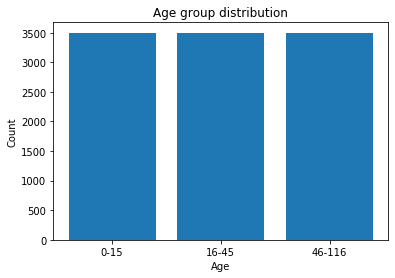

In [58]:
import matplotlib.pyplot as plt
from collections import Counter

c = Counter(ages)
plt.bar(c.keys(), c.values())
plt.xticks(np.arange(3),['0-15','16-45','46-116'])
plt.xlabel('Age')
plt.ylabel('Count')
plt.title("Age group distribution")
plt.show()

In [7]:
from sklearn.model_selection import train_test_split
import sklearn
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(img_data, ages, test_size=0.25)

print(len(X_train))
print(len(X_test))

7877
2626


In [8]:
from sklearn.preprocessing import label_binarize
y_train = label_binarize(y_train, classes=[0, 1, 2])
y_test = label_binarize(y_test, classes=[0, 1, 2])

In [61]:
X_test.shape

(2626, 224, 224, 3)

In [62]:
X_train.shape

(7877, 224, 224, 3)

In [25]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(img_data, ages, test_size=0.25)

In [23]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Activation
import time
from keras.utils import np_utils
import keras.callbacks as cb
from keras.optimizers import RMSprop
from keras import regularizers
from keras.optimizers import SGD

### VGG pre-trained Model

In [9]:
from keras_vggface.vggface import VGGFace

# Based on VGG16 architecture -> old paper(2015)
vggface = VGGFace(model='vgg16')

Using TensorFlow backend.


In [10]:
from keras.engine import  Model
from keras.layers import Input
from keras_vggface.vggface import VGGFace

# Convolution Features
vgg_features = VGGFace(include_top=False, input_shape=(224, 224, 3), pooling='avg')

In [11]:
from keras.engine import  Model
from keras.layers import Flatten, Dense, Input
from keras_vggface.vggface import VGGFace

#custom parameters
nb_class = 3
hidden_dim = 128

vgg_model = VGGFace(include_top=False, input_shape=(224,224,3))
last_layer = vgg_model.get_layer('pool5').output
x = Flatten(name='flatten')(last_layer)
x = Dense(hidden_dim, activation='relu', name='fc6')(x)
x = Dense(hidden_dim, activation='relu', name='fc7')(x)
out = Dense(nb_class, activation='softmax', name='fc8')(x)
custom_vgg_model = Model(vgg_model.input, out)

In [12]:
custom_vgg_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics=['accuracy'])
history = custom_vgg_model.fit(X_train, y_train, batch_size = 64, epochs = 10)
score = custom_vgg_model.evaluate(X_test, y_test, verbose=1)
print("\nNetwork's test loss and accuracy: " + format(score))



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10
7877/7877 [==============================] - 4993s 634ms/step - loss: 0.6531 - acc: 0.7354
Epoch 2/10
7877/7877 [==============================] - 4940s 627ms/step - loss: 0.3235 - acc: 0.8728
Epoch 3/10
7877/7877 [==============================] - 4929s 626ms/step - loss: 0.2601 - acc: 0.8979
Epoch 4/10
7877/7877 [==============================] - 4929s 626ms/step - loss: 0.2478 - acc: 0.9116
Epoch 5/10
7877/7877 [==============================] - 4931s 626ms/step - loss: 0.1666 - acc: 0.9391
Epoch 6/10
7877/7877 [==============================] - 4948s 628ms/step - loss: 0.1171 - acc: 0.9581
Epoch 7/10
7877/7877 [==============================] - 4948s 628ms/step - loss: 0.1035 - acc: 0.9636
Epoch 8/10
7877/7877 [==============================] - 4963s 630ms/step - loss: 0.0716 - acc: 0.9769
Epoch 9/10
7877/7877 [==============================] - 4984s 633ms/step - loss: 0.060

In [14]:
score = custom_vgg_model.evaluate(X_train, y_train, verbose=1)
print("\nNetwork's train loss and accuracy: " + format(score))


Network's train loss and accuracy: [0.006711815388158382, 0.9987304811476451]
